# DengAI: Predicting Disease Spread

### Problem description

Your goal is to predict the total_cases label for each (city, year, weekofyear) in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each city have been concatenated along with a city column indicating the source: sj for San Juan and iq for Iquitos. The test set is a pure future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have been filled as NaNs.

### Performance metric

Mean absolute error

### Features

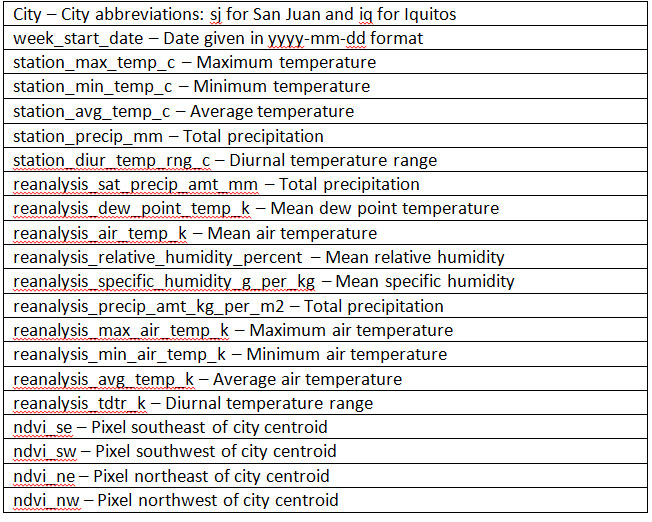

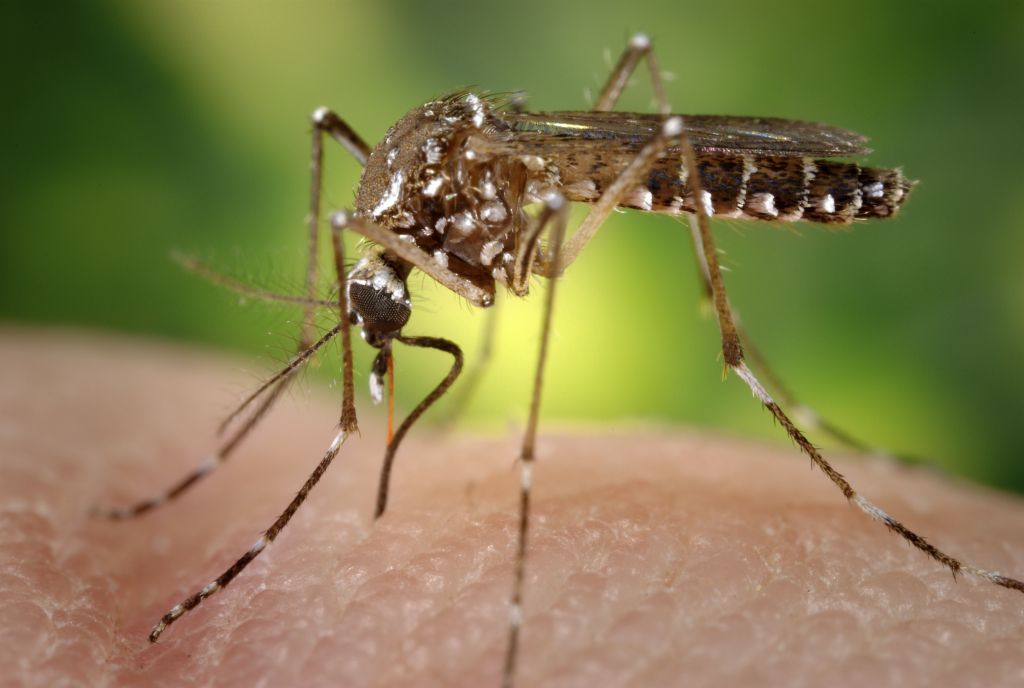

In [394]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import time # to record training and testing time
import matplotlib.pyplot as plt # for plotting
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from statsmodels.tools import eval_measures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso


In [395]:
# Read data into pandas dataframes

train = pd.read_csv('dengue_features_train.csv')
test = pd.read_csv('dengue_features_test.csv')
labels = pd.read_csv('dengue_labels_train.csv')

features = list(train)[0:]
print("Training: %d rows, %d columns" %train.shape)
print("Test: %d rows, %d columns" %test.shape)
print("Labels: %d rows, %d columns" %labels.shape)
print("Number of features = %d" %len(features))


Training: 1456 rows, 24 columns
Test: 416 rows, 24 columns
Labels: 1456 rows, 4 columns
Number of features = 24


In [396]:
# Simple data exploration
train.isna().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [397]:
test.isna().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

In [398]:
na_features = list(train)[4:]

In [399]:
# Divide the dataset based on SJ & IQ
sj_train = train[train['city']=='sj']
iq_train = train[train['city']=='iq']

sj_test = test[test['city']=='sj']
iq_test = test[test['city']=='iq']

sj_labels = labels[labels['city']=='sj']
iq_labels = labels[labels['city']=='iq']

In [400]:
sj_train

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,sj,2008,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,sj,2008,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,sj,2008,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,sj,2008,16,2008-04-15,0.001800,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2


In [401]:
# Impute the n/a values with mean
def impute_features(data):
    for feature in na_features:
        data[feature].fillna(method='ffill', inplace=True)
    
impute_features(sj_train) 
impute_features(iq_train) 
impute_features(sj_test) 
impute_features(iq_test)

In [402]:
# Add on total_cases as a feature to the training dataset for both the cities
sj_train['total_cases'] = sj_labels['total_cases']
iq_train['total_cases'] = iq_labels['total_cases']

In [403]:
iq_train

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
937,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
938,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
939,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
940,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


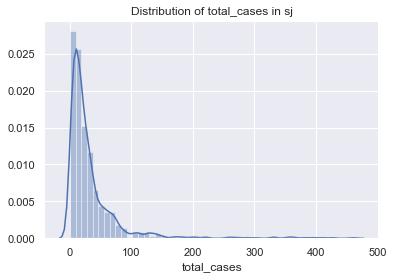

In [404]:
# Check the distribution of the target variable for San Juan
target = sj_train.total_cases
plt.figure()
sns.distplot(target)
plt.title('Distribution of total_cases in sj')
plt.show()

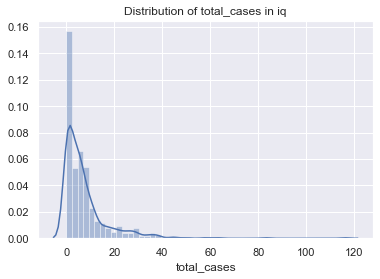

In [405]:
# Check the data distribution for Iquitos
target_iq = iq_train.total_cases
plt.figure()
sns.distplot(target_iq)
plt.title('Distribution of total_cases in iq')
plt.show()

#### Distribution of data

1. The target variable total_cases is skewed for both the cities San Juan and Iquitos.
2. Most of the observations have cases less than 30

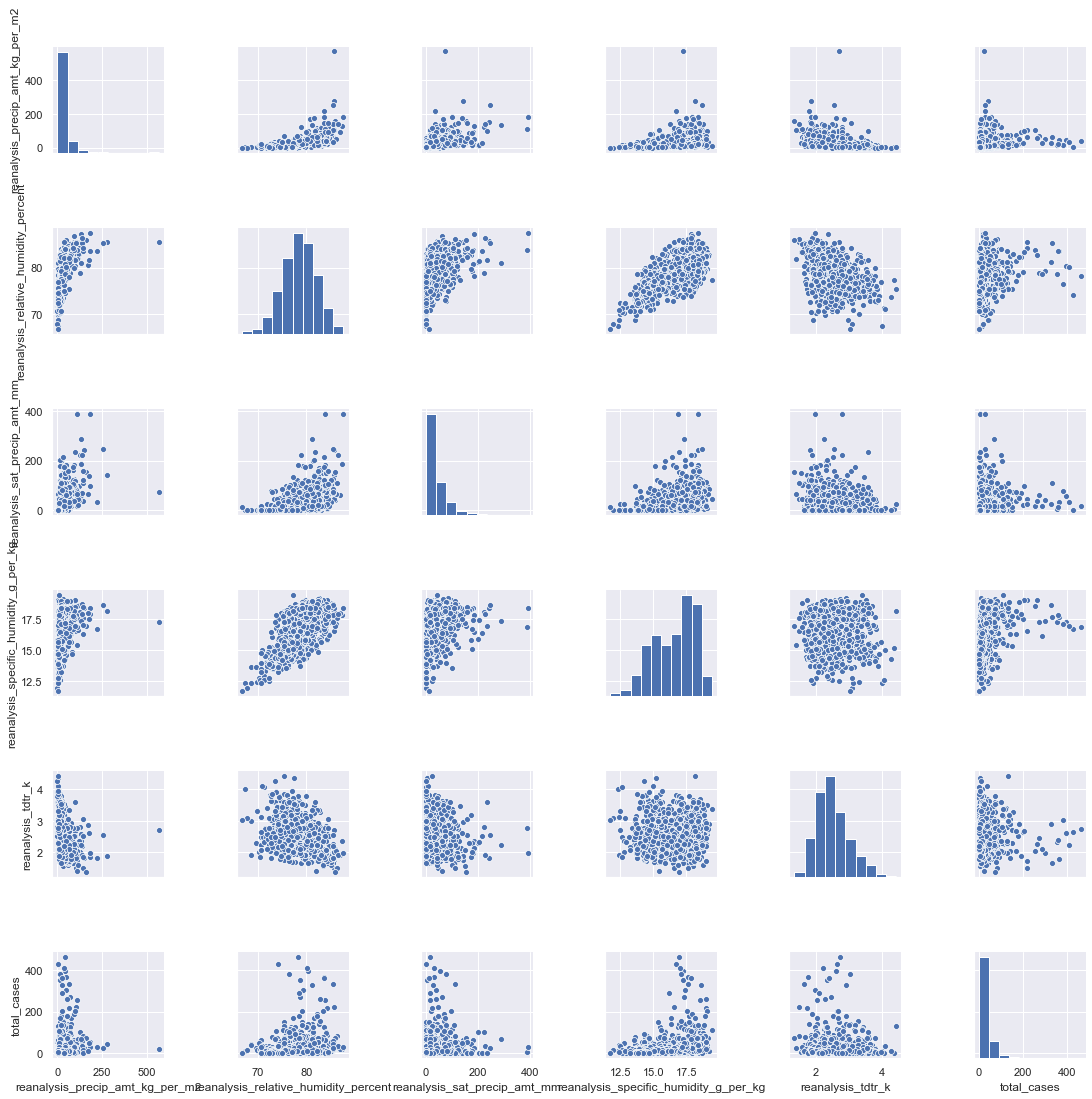

In [407]:
feat_1 = ['reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent','reanalysis_sat_precip_amt_mm'
          ,'reanalysis_specific_humidity_g_per_kg','reanalysis_tdtr_k','total_cases']
sns.pairplot(sj_train[feat_1])

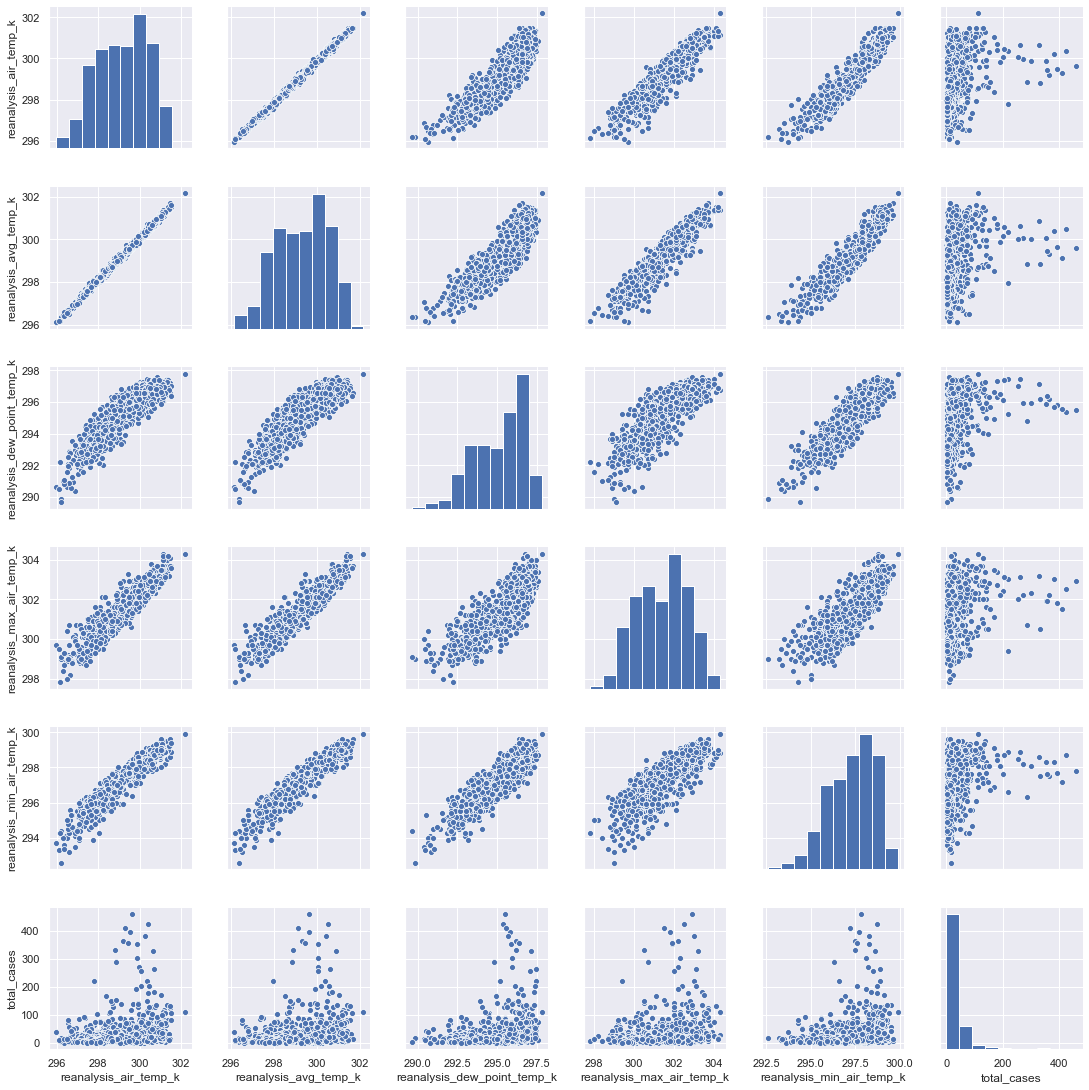

In [408]:
feat_1 = ['reanalysis_air_temp_k','reanalysis_avg_temp_k','reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k',
'reanalysis_min_air_temp_k','total_cases']
sns.pairplot(sj_train[feat_1])

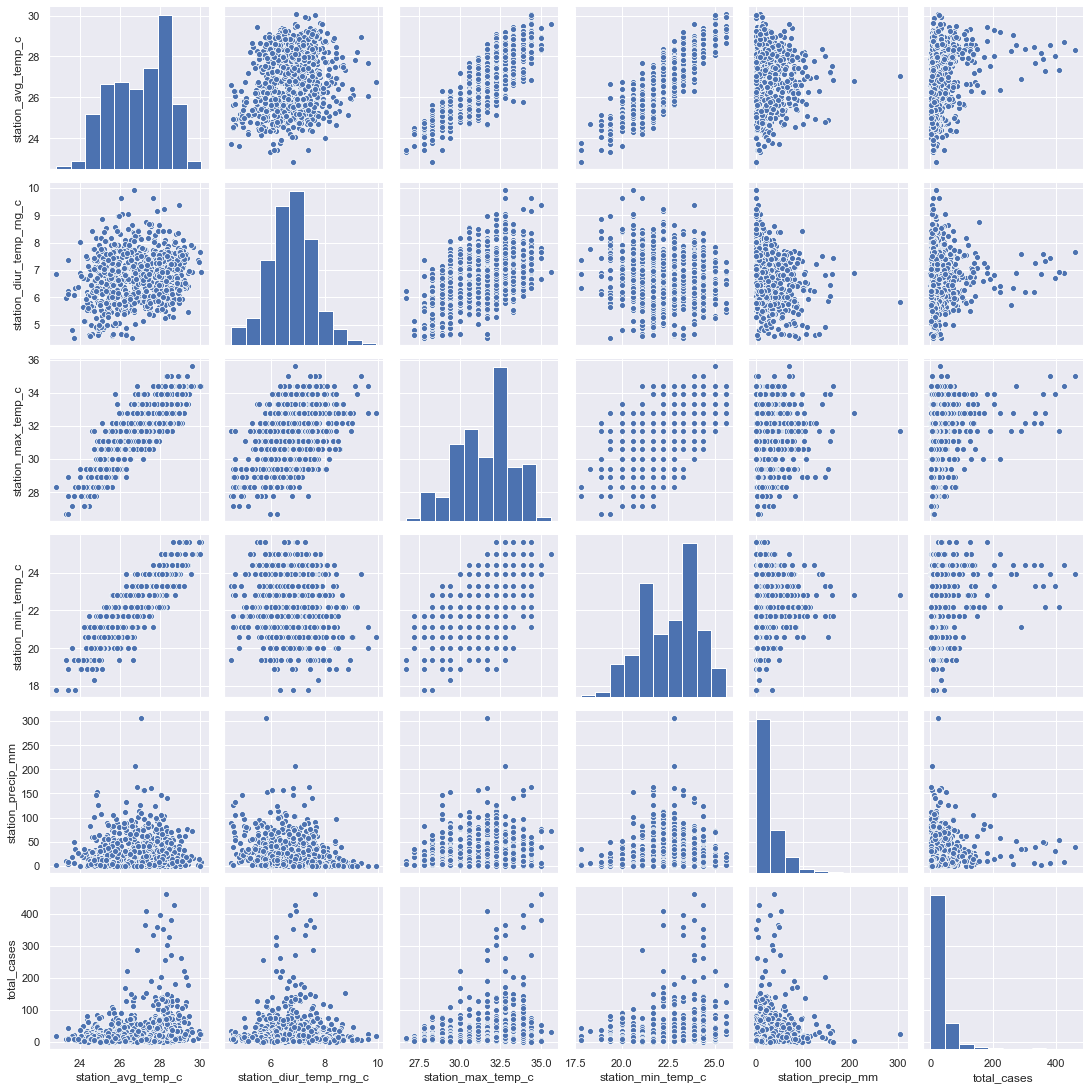

In [409]:
feat_1 = ['station_avg_temp_c','station_diur_temp_rng_c','station_max_temp_c','station_min_temp_c',
'station_precip_mm','total_cases']
sns.pairplot(sj_train[feat_1])

#### Pair Plot inference

* No variables are exceptionally good at predicting the label (total cases)

* The first 4 variables (Normalized Difference Vegetation Index) variables appears to be very weakly correlated with the other variables. They do not appear to be very useful in predicting the labels.

* Most of temperature variables in both datasets appear to be strongly correlated with one another.

In [410]:
sj_train.drop(columns=['week_start_date','city','year','weekofyear'], axis = 1, inplace = True)
iq_train.drop(columns=['week_start_date','city','year','weekofyear'], axis = 1, inplace = True)
sj_test.drop(columns=['week_start_date','city','year','weekofyear'], axis = 1, inplace = True)
iq_test.drop(columns=['week_start_date','city','year','weekofyear'], axis = 1, inplace = True)


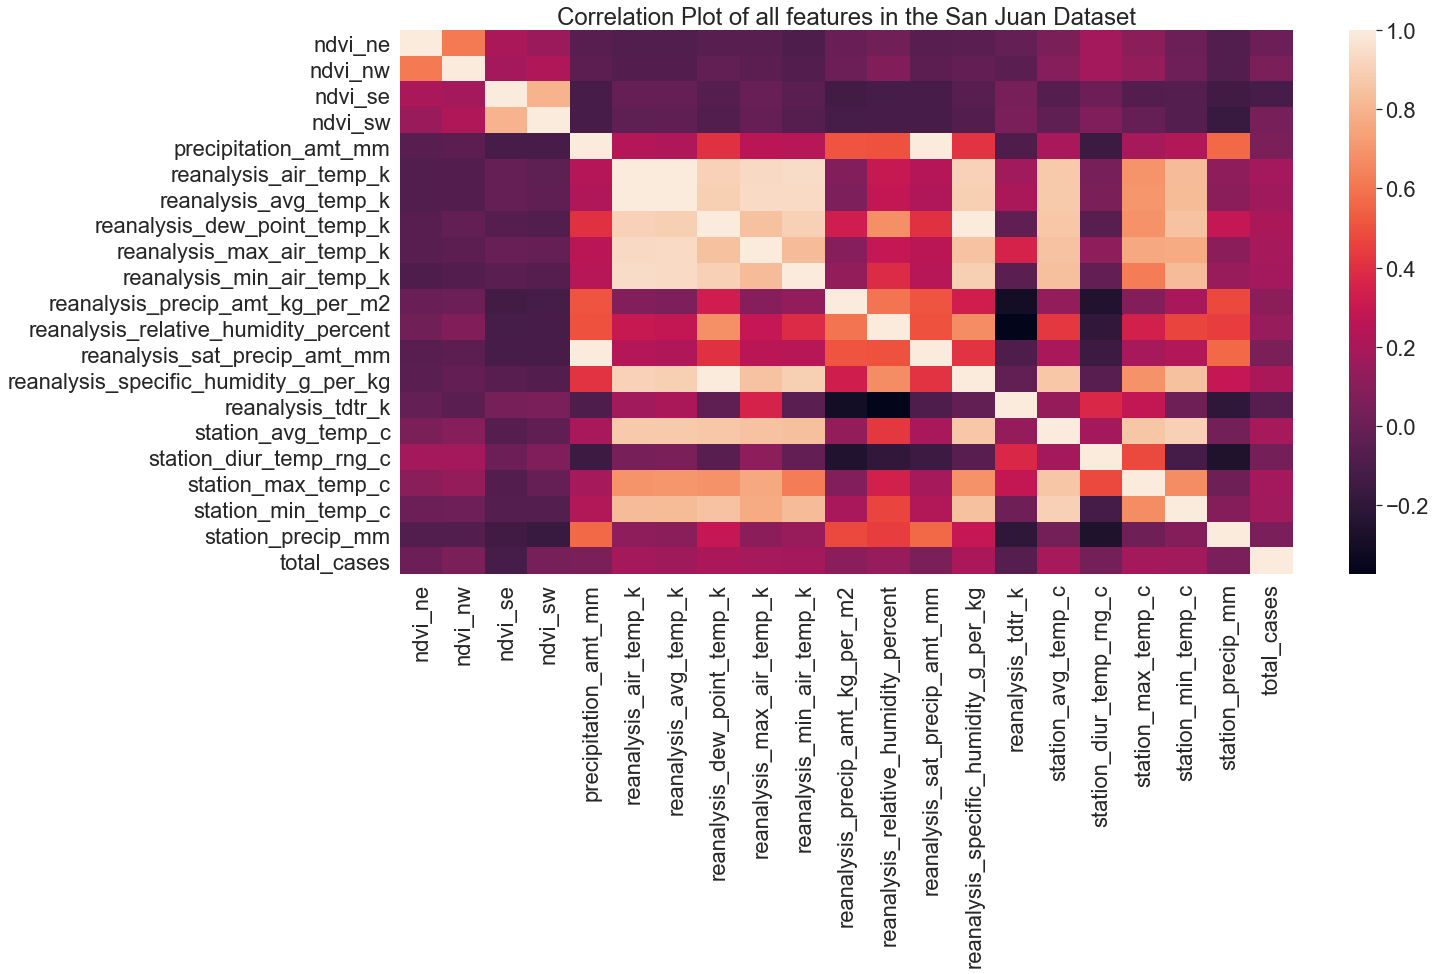

In [411]:
sj_corr = sj_train.corr()

sns.set(font_scale = 2)
plt.figure(figsize=(20, 10))

sns.heatmap(sj_corr)
plt.title('Correlation Plot of all features in the San Juan Dataset')
plt.show()

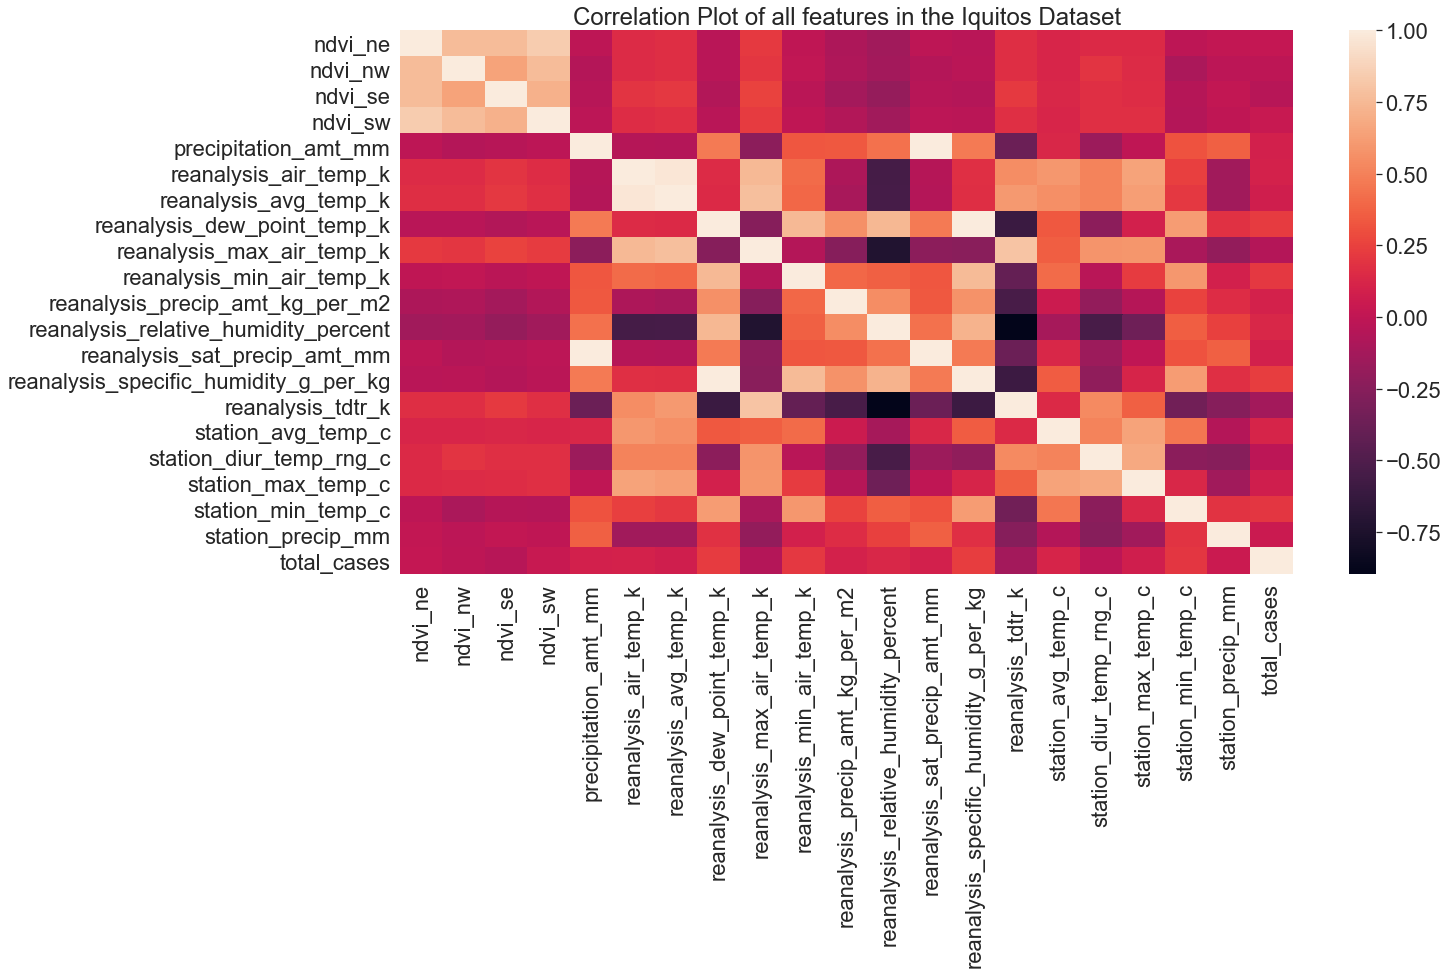

In [412]:
iq_corr = iq_train.corr()

plt.figure(figsize=(20, 10))

sns.heatmap(iq_corr)
plt.title('Correlation Plot of all features in the Iquitos Dataset')
plt.show()

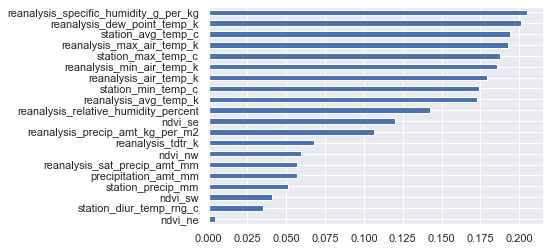

In [413]:
sns.set(font_scale = 1.0)
(abs(sj_corr)
 .total_cases
 .drop('total_cases')
 .sort_values()
 .plot
 .barh())

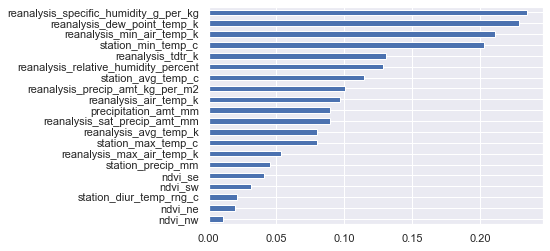

In [414]:
sns.set(font_scale = 1.0)
(abs(iq_corr)
 .total_cases
 .drop('total_cases')
 .sort_values()
 .plot
 .barh())

### Features based on the scale of importance 

'reanalysis_specific_humidity_g_per_kg', 
'reanalysis_dew_point_temp_k',
'reanalysis_min_air_temp_k', 
'station_min_temp_c',
'reanalysis_relative_humidity_percent'

In [415]:
imp_features = iq_corr.total_cases.drop('total_cases').sort_values(ascending = False).index[0:5]
imp_features

Index(['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k',
       'reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_relative_humidity_percent'],
      dtype='object')

In [416]:
sj_train_df = sj_train[imp_features]
iq_train_df = iq_train[imp_features]

sj_target = sj_train['total_cases']
iq_target = iq_train['total_cases']

sj_test_df = sj_test[imp_features]
iq_test_df = iq_test[imp_features]

After conducting our simple exploratory data analysis, we proceed to split the dataset into training and cross validation dataset. This can be done by calling the function:
##### train_test_split


In [418]:
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(sj_train_df, sj_target, test_size=0.2, random_state=0)

In [419]:
iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(iq_train_df, iq_target, test_size=0.2, random_state=0)

### Modelling on various Regressor models
1. Linear Regression
2. Linear Ridge Regression
3. Linear Lasso Regression
4. Random Forest Regressor
5. Decision Tree Regressor
6. Gradient Boost Regressor

##### Check the metric of measure MAE and the model having the least measure of MAE can be choosen as the final model

In [420]:
def best_linear_model(train_X, train_y,test_X , test_y):
    model = linear_model.LinearRegression()
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    mape = eval_measures.meanabs(y_pred, test_y)

    total_X = pd.concat([train_X, test_X])
    total_y = pd.concat([train_y, test_y])
    print ('Linear Regression Model: ', mape)
    return model.fit(total_X, total_y)    
#best_linear_model(sj_X_train, sj_y_train,sj_X_test , sj_y_test)

In [421]:
def best_ridge_model(train_X, train_y,test_X , test_y):
    ridge = Ridge(random_state = 10)
    
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]  #0.1
    param_grid = dict(alpha=alpha)
    model = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_absolute_error', 
                         verbose=1, n_jobs=-1,cv = 10)
    
    ridgereg = model.fit(train_X,train_y)
        
    cv_pred = ridgereg.predict(test_X)
    mae = eval_measures.meanabs(cv_pred, test_y)
        
    total_X = pd.concat([train_X, test_X])
    total_y = pd.concat([train_y, test_y])
    print ('Ridge Regression Model: ', mae)
    return model.fit(total_X, total_y)

#best_ridge_model(sj_X_train,sj_y_train,sj_X_test,sj_y_test)

In [422]:
def best_lasso_model(train_X, train_y,test_X , test_y):
    lasso = Lasso(random_state = 10)
    
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]  #0.001
    param_grid = dict(alpha=alpha)
    model = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_absolute_error', verbose=1, 
                         n_jobs=-1,cv = 10)
    lassoreg = model.fit(train_X,train_y)
        
    cv_pred =  lassoreg.predict(test_X)
    mae = eval_measures.meanabs(cv_pred, test_y)
        
    total_X = pd.concat([train_X, test_X])
    total_y = pd.concat([train_y, test_y])
    print ('Lasso Regression Model: ', mae)
    return model.fit(total_X, total_y)

#best_lasso_model(sj_X_train,sj_y_train,sj_X_test,sj_y_test)


In [423]:
sj_linear_model = best_linear_model(sj_X_train, sj_y_train,sj_X_test , sj_y_test)
iq_linear_model = best_linear_model(iq_X_train, iq_y_train,iq_X_test , iq_y_test)

Linear Regression Model:  26.60653382110337
Linear Regression Model:  7.263792118285691


In [424]:
sj_ridge_model= best_ridge_model(sj_X_train,sj_y_train,sj_X_test,sj_y_test)
iq_ridge_model = best_ridge_model(iq_X_train,iq_y_train,iq_X_test,iq_y_test)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    4.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Ridge Regression Model:  26.711787572248593
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Ridge Regression Model:  7.2627487965279744
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished


In [425]:
sj_lasso_model = best_lasso_model(sj_X_train,sj_y_train,sj_X_test,sj_y_test)
iq_lasso_model = best_lasso_model(iq_X_train,iq_y_train,iq_X_test,iq_y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Lasso Regression Model:  26.644598328950188
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Lasso Regression Model:  7.255733289739606
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished


In [426]:
from sklearn.ensemble import RandomForestRegressor
def best_regressor_model(train_X, train_y,test_X , test_y):
    regressor = RandomForestRegressor(n_estimators = 100, random_state = 0,max_depth =4,
                                      max_features=4)
    regressor.fit(train_X, train_y)
    y_pred = regressor.predict(test_X)
    mae = eval_measures.meanabs(y_pred, test_y)
    
    total_X = pd.concat([train_X, test_X])
    total_y = pd.concat([train_y, test_y])    
    
    print ('Random Forest Regressor Model: ', mae)
    return regressor.fit(total_X, total_y)

In [480]:
sj_rfreg_model = best_regressor_model(sj_X_train, sj_y_train,sj_X_test , sj_y_test)
iq_rfreg_model = best_regressor_model(iq_X_train, iq_y_train,iq_X_test , iq_y_test)

Random Forest Regressor Model:  26.391106056708036
Random Forest Regressor Model:  7.058214766593658


In [442]:
from sklearn.tree import DecisionTreeRegressor
def best_decisiontree_model(train_X, train_y,test_X , test_y):
    regressor = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=10,
                           max_leaf_nodes=100,criterion = 'mae')
    regressor.fit(train_X, train_y)
    y_pred = regressor.predict(test_X)
    mae = eval_measures.meanabs(y_pred, test_y)
    
    total_X = pd.concat([train_X, test_X])
    total_y = pd.concat([train_y, test_y])    
    
    print ('Decision Tree Regressor Model: ', mae)
    return regressor.fit(total_X, total_y)

In [443]:
sj_dsreg_model = best_decisiontree_model(sj_X_train, sj_y_train,sj_X_test , sj_y_test)
iq_dsreg_model = best_decisiontree_model(iq_X_train, iq_y_train,iq_X_test , iq_y_test)

Decision Tree Regressor Model:  24.164893617021278
Decision Tree Regressor Model:  6.6875


In [436]:
from sklearn.ensemble import GradientBoostingRegressor
def best_gradboost_model(train_X, train_y,test_X , test_y):
    GBoost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
    GBoost.fit(train_X, train_y)
    y_pred = GBoost.predict(test_X)
    mae = eval_measures.meanabs(y_pred, test_y)
    
    total_X = pd.concat([train_X, test_X])
    total_y = pd.concat([train_y, test_y])    
    
    print ('Gradient Boosting Regressor Model: ', mae)
    return GBoost.fit(total_X, total_y)

In [437]:
sj_gb_model = best_gradboost_model(sj_X_train, sj_y_train,sj_X_test , sj_y_test)
iq_gb_model = best_gradboost_model(iq_X_train, iq_y_train,iq_X_test , iq_y_test)

Gradient Boosting Regressor Model:  23.97817328213134
Gradient Boosting Regressor Model:  6.835155424373148


### Scores of the models

* Linear Regression Model for SJ:  23.372312994769963
* Linear Regression Model for IQ:  6.796203990035329


* Ridge Regression Model for SJ:  23.558182161402772
* Ridge Regression Model for IQ:  6.796151741906554


* Lasso Regression Model for SJ:  23.362136041111135
* Lasso Regression Model for IQ:  6.786984405731608


* Random Forest Regressor Model for SJ:  23.778794282543068
* Random Forest Regressor Model for IQ:  6.534216646685393


* Decision Tree Regressor Model for SJ:  23.46479761859979
* Decision Tree Regressor Model for IQ:  6.350630816064368


* Gradient Boosting Regressor Model for SJ:  23.744933179041322
* Gradient Boosting Regressor Model for IQ:  6.744875532183025

In [481]:
y_sj_test = pd.Series(sj_rfreg_model.predict(sj_test_df))
y_iq_test = pd.Series(iq_rfreg_model.predict(iq_test_df))

### Improving performance

Ensemble learning is a machine learning paradigm where multiple models (often called “weak learners”) are trained to solve the same problem and combined to get better results.

In ensemble learning theory, we call weak learners (or base models) models that can be used as building blocks for designing more complex models by combining several of them. Most of the time, these basics models perform not so well by themselves either because they have a high bias (low degree of freedom models, for example) or because they have too much variance to be robust (high degree of freedom models, for example). Then, the idea of ensemble methods is to try reducing bias and/or variance of such weak learners by combining several of them together in order to create a strong learner (or ensemble model) that achieves better performances.

### Averaging Models
We construct the point forecast by combining predictions from all possible linear regression models, given a set of potentially relevant predictors. We take an average of the relevant predictors.

In [123]:
def averagingModels(X, train, labels, models=[]):
    for model in models:
        model.fit(train, labels)
        predictions = np.column_stack([
        model.predict(X) for model in models
    ])
    return np.mean(predictions, axis=1)

In [476]:
y_sj_test = pd.Series(averagingModels(sj_test_df, sj_X_train, sj_y_train, [sj_linear_model, sj_rfreg_model,sj_lasso_model ]))
y_iq_test = pd.Series(averagingModels(iq_test_df, iq_X_train, iq_y_train, [iq_linear_model, iq_rfreg_model, iq_lasso_model ]))

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished


In [482]:
submission = pd.read_csv('submission_format.csv')
submission_ = y_sj_test.append(y_iq_test, ignore_index=True)

In [483]:
submission['total_cases'] = np.floor(submission_).astype(np.int64)
submission.to_csv('submission.csv', index = False)

In [484]:
submission

,city,year,weekofyear,total_cases
0,sj,2008,18,22
1,sj,2008,19,19
2,sj,2008,20,35
3,sj,2008,21,31
4,sj,2008,22,42
...,...,...,...,...
411,iq,2013,22,8
412,iq,2013,23,4
413,iq,2013,24,4
414,iq,2013,25,3


### Conclusion
The public score in DengAI: Disease spread prediction (DrivenData Competition) MAE that I could reach 25.5313